In [1]:
import copy
from enum import Enum
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from matplotlib.colors import TwoSlopeNorm

from mimt import *

mi.set_variant("cuda_ad_rgb")

class Setting(Enum):
    Direct = 1
    VaryingBRDF = 2
    IndirectIllumination = 3

In [52]:
def create_scene(setting: Setting, integrator: str):
    texture = create_gradient_image(256, 256, color_1=[1, 0, 0], color_2=[0, 0, 1])

    absorption  = 0.
    scattering  = 0.0

    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": 5,
            "hide_emitters": False,
            #"reparam_antithetic":True,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                # origin = [8, 2.0, -1.707106781-1],
                # target = [0, 1.5, -1.707106781-1],
                origin = [0, 0, 0],
                target = [0, 0, -1],
                up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 128,
                "height": 128,
                "sample_border": True,
            },
            "sampler": { "type": "stratified", "sample_count": 22**2 },
        },

        "bsdf": {
            'type': 'blendbsdf',
            'weight': scattering,
            'bsdf_0': {'type': 'roughconductor',
                       'alpha': 0.2 ,
                       'specular_reflectance': 1. - absorption,
                       'distribution': 'beckmann'},
            'bsdf_1': { 'type': 'diffuse' , 'reflectance': 1. - absorption },
        },
        
        "surface_1": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = np.array([0,  0, -1]),
                target = np.array([0,  0, -1]) + np.array([0,  1, 1]),
                up=[0, 1, 0]
            ).scale(1),
        },

        "surface_2": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = np.array([0,  1.707106781, -1]),
                target = np.array([0,  1.707106781, -1]) + np.array([0,  -1, -1]),
                up=[0, 1, 0]
            ).scale(1),
        },
        
        "surface_3": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = np.array([0,  1.707106781, -2.414213562-2]),
                target = np.array([0,  1.707106781, -2.414213562-2]) + np.array([0,  -1, 1]),
                up=[0, 1, 0]
            ).scale(1),
        },
        "surface_4": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = np.array([0,  0, -2.414213562-2]),
                target = np.array([0,  0, -2.414213562-2])  + np.array([0,  1, -1]),
                up=[0, 1, 0]
            ).scale(1),
        },
    }
    bsdf = { "type": "ref", "id": "bsdf" }
    emitter = { 
        "type": "area",
        "radiance": {
            'type': 'bitmap',
            'data': 5*texture,
            'raw': True
        }
    }

    if setting == Setting.Direct:
        scene_dict["surface_4"]["emitter"] = emitter
        scene_dict["surface_3"]["bsdf"] = bsdf
        scene_dict["surface_2"]["bsdf"] = bsdf
        scene_dict["surface_1"]["bsdf"] = bsdf

    return scene_dict

def apply_transform(pi: str, params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params[pi] = mi.Transform4f.translate([0, 0, offset]) @ original
    params.update()
    return params

def compute_gradient_finite_differences(func: callable, x: float, h: float = 0.01):
    return (func(x + h) - func(x - h)) / (2*h)

def compute_gradient_forward(func: callable, x: float):
    x_attached = mi.Float(x)
    dr.enable_grad(x_attached)

    output = func(x_attached)

    dr.set_grad(x_attached, 1)
    dr.forward_from(x_attached)
    return dr.grad(output)

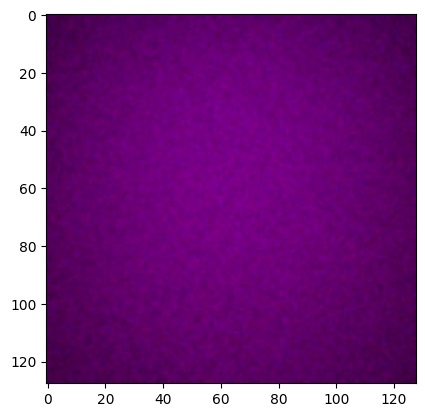

In [56]:
scene = mi.load_dict(create_scene(Setting.Direct, "prb"))
img = mi.render(scene, seed=0)
plt.imshow(mi.Bitmap(img).convert(srgb_gamma=True))

In [63]:
data = {}

integrators = ["path", "prb", "prb_basic", "prb_projective"]
integrators = ["path", "prb", "prb_basic", "prb_reparam"]

scene = mi.load_dict(create_scene(Setting.Direct, integrator=integrators[3]))

pi = 'surface_2.to_world'
params   = mi.traverse(scene)
original = mi.Transform4f(params[pi])

# Render primal image
render_with_offset = lambda x: mi.render(scene, params=apply_transform(pi, params, original, x), seed=0)

img = mi.render(scene, params=params, seed=0)
grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.01).numpy()
grad_fw = compute_gradient_forward(render_with_offset, 0.).numpy()

RuntimeError: ​[PluginManager] Plugin "prb_projective" not found!

1.1140103 0.0


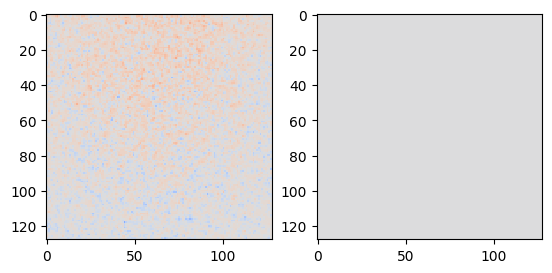

In [64]:
print(np.max(grad_fd),np.max(grad_fw))
fig, axs = plt.subplots(1, 2)
vmax=grad_fd[...,0].max()*2
axs[0].imshow(grad_fd[...,0], cmap='coolwarm_r', vmin=-vmax, vmax=vmax, interpolation='none')
#vmax=grad_fw[...,0].max()*2
axs[1].imshow(grad_fw[...,0], cmap='coolwarm_r', vmin=-vmax, vmax=vmax, interpolation='none')

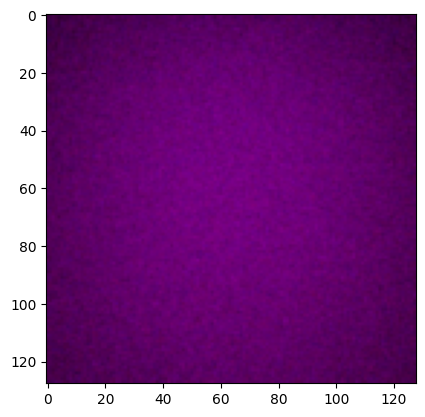

In [51]:
plt.imshow(mi.Bitmap(render_with_offset(0.1)).convert(srgb_gamma=True))